# Convolutional Neural Network, Fashion MNIST

MLP를 훈련하여 이미지 분류기를 생성해 본다. 
[Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)을 사용한다. 

![img](../assets/fashion-mnist-sprite.png)

다음과 같은 절차로 수행한다.:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

시작하기 위해 필요한 패키지를 import한다.

In [1]:
# import libraries
import torch
import numpy as np

---
## 1. Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

torchvision에서 제공되는 Fashion MNIST 데이터 셋을 다운로드 하여 수행한다. `batch_size`는 필요에 따라 선택할 수 있다.  
Fashion MNIST 데이터 셋을 dataloader를 생성하여 신경망의 입력 데이터로 사용한다.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split

In [3]:
# how many samples per batch to load
batch_size = 20
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='../data', train=True,
                                   download=True, transform=transform)
train_data, valid_data = random_split(train_data, [50000, 10000])

test_data = datasets.FashionMNIST(root='../data', train=False,
                                  download=True, transform=transform)

C:\Users\aoneko\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Visualize a Batch of Training Data

모형을 구성하기 전에 읽어 들인 데이터를 확인하는 차원에서 이미지 데이터를 확인한다.  


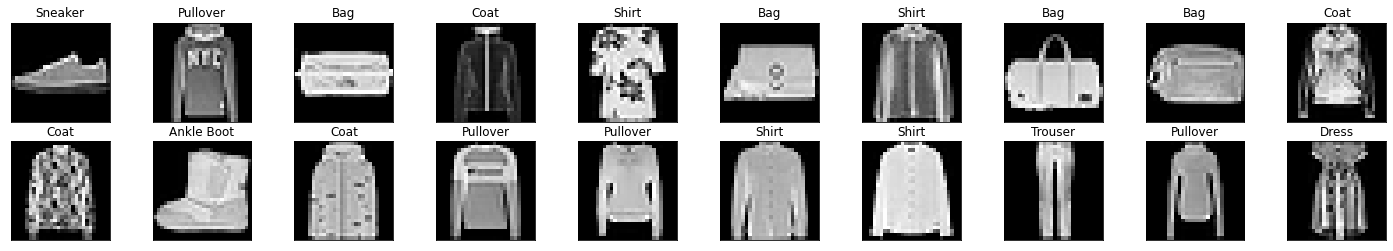

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

class_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(class_name[labels[idx].item()])

### View an Image in More Detail
개별적으로 이미지 하나를 출력해 보면 다음과 같다.

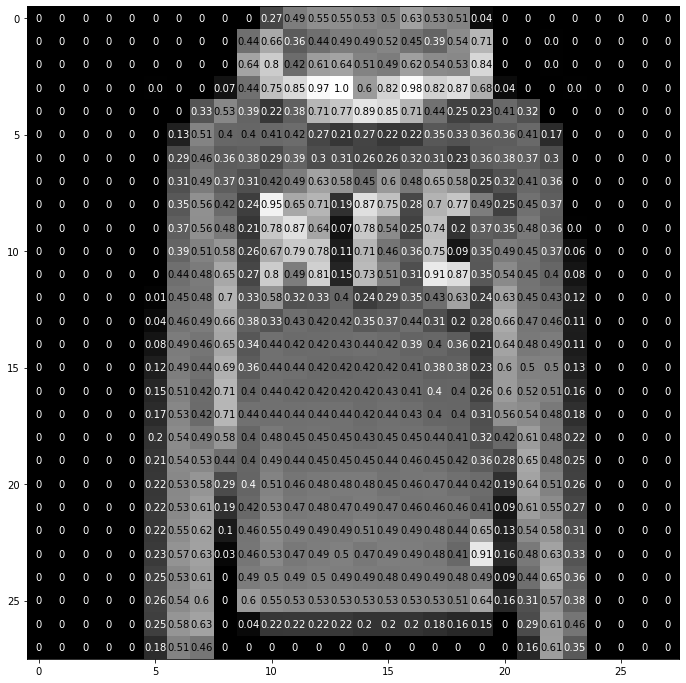

In [6]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## 2. Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


- 2개의 Conv2d layer로 구성한다.
- overfitting을 피하기 위해 dropout을 사용한다.


In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

classification을 위해서 loss 함수는 cross-entropy를 사용한다. 

In [8]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters())

---
## 3. Train the Network

각각의 batch에 대하여 다음과 같은 순서로 훈련을 진행한다.:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

epoch의 횟수는 훈련시간을 고려하여 정하도록 한다. n_epochs=10으로 하면 훈련시간은 약 6~7분 정도 소요될 것이다.  
훈련이 진행되면서 loss의 감소를 확인한다.

In [9]:
# number of epochs to train the model
n_epochs = 10

print('Training the model..........')
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))


Training the model..........


C:\Users\aoneko\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.714876 	Validation Loss: 0.476128
Epoch: 2 	Training Loss: 0.492690 	Validation Loss: 0.391505
Epoch: 3 	Training Loss: 0.433458 	Validation Loss: 0.353153
Epoch: 4 	Training Loss: 0.402026 	Validation Loss: 0.342998
Epoch: 5 	Training Loss: 0.379908 	Validation Loss: 0.342411
Epoch: 6 	Training Loss: 0.363456 	Validation Loss: 0.312947
Epoch: 7 	Training Loss: 0.353889 	Validation Loss: 0.305752
Epoch: 8 	Training Loss: 0.341612 	Validation Loss: 0.299657
Epoch: 9 	Training Loss: 0.333087 	Validation Loss: 0.292707
Epoch: 10 	Training Loss: 0.326402 	Validation Loss: 0.301083


---
## 4. Test the Trained Network

마지막으로 best model을 이용하여 **test data**를 사용하여 생성된 모형을 테스트한다.  
훈련에 사용되지 않은 테스트 데이터를 사용하여 모형을 평가한다. 
test loss와 accuracy로 평가할 수 있다.


In [10]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %15s: %2d%% (%2d/%2d)' % (
            class_name[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.320060

Test Accuracy of     T-shirt/top: 90% (904/1000)
Test Accuracy of         Trouser: 97% (973/1000)
Test Accuracy of        Pullover: 87% (877/1000)
Test Accuracy of           Dress: 91% (911/1000)
Test Accuracy of            Coat: 71% (719/1000)
Test Accuracy of          Sandal: 98% (981/1000)
Test Accuracy of           Shirt: 56% (569/1000)
Test Accuracy of         Sneaker: 93% (934/1000)
Test Accuracy of             Bag: 97% (978/1000)
Test Accuracy of      Ankle Boot: 97% (970/1000)

Test Accuracy (Overall): 88% (8816/10000)


### Visualize Sample Test Results

테스트 결과를 시각적으로 판단할 수 있다.  
해당 테스트 결과에서 `predicted (ground-truth)`형태로 예측값을 확인한다. 모형에 의한 예측값이 실제 데이터의 참값(ground-truth)를 맞추었으면 녹색 틀리면 빨간색으로 표시한다.

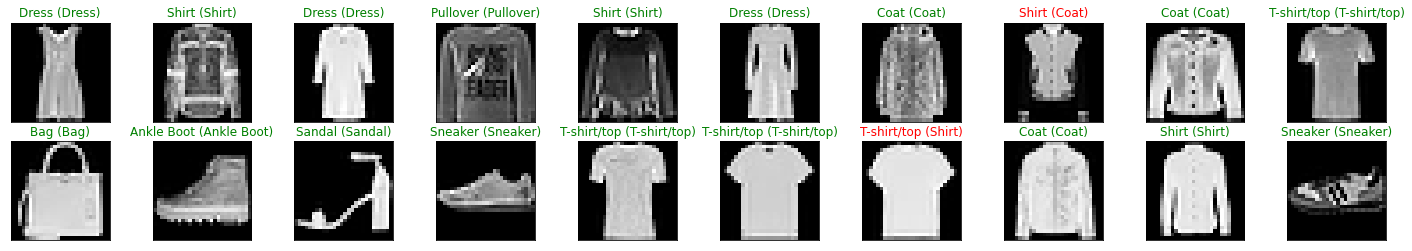

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

model.eval()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(class_name[preds[idx].item()], class_name[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))